<font size="10">Discovering PDEs with PINNs</font>

<font size="4">In this notebook we use PINNs to discover the heat equation 
$u_t = \nu u_{xx}$. Here the parameter $\nu$ is the thermal diffusivity and represents the primary system coefficient we attempt to identiy. We gather data from the exact solution $u(x,t) = \mathrm{e}^{-0.1\pi^2 t}\cos(\pi x)$ at randomly sampled locations in the space-time domain $[-1,1] \times [0,1]$. The number of sample points is denoted N_d in the following code.</font>

<font size="4">This code was written by Mohit Sahu and accompanies the work in Section 5.5 of the book. <i>Data-Driven Methods for Dynamic Systems</i>. This script was adapted from the Tensorflow version by Jason J. Bramburger. We use PyTorch 2.3.0 to build the neural network</font>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from time import time
import numpy as np

In [2]:
dtype=torch.float32

# set constants
pi = torch.tensor(np.pi)

# Define exact solution
def fun_u(t,x):
    return torch.exp(-0.1*t*pi**2)*torch.cos(pi*x) #6*(x+1)*( (x+1)**3 - 24*t )/( (x+1)**3 + 12*t )**2

In [3]:
# Set number of data points
N_r = 10000
N_d = 500

# Set boundary
tmin = 0.
tmax = 1.0
xmin = -1.
xmax = 1.

# Device over which model has to be trained
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Lower bounds
lb = torch.tensor([tmin, xmin]).to(device)
# Upper bounds
ub = torch.tensor([tmax, xmax]).to(device)

# Set random seed for reproducible results
torch.manual_seed(0)

# Draw uniformly sampled collocation points
t_r = torch.rand((N_r,1), requires_grad=True).to(device)*(ub[0]-lb[0]) + lb[0]
x_r = torch.rand((N_r,1), requires_grad=True).to(device)*(ub[1]-lb[1]) + lb[1]
X_r = torch.concat([t_r, x_r], axis=1)

# Draw uniformly sampled sample points
t_d = torch.rand((N_d,1)).to(device)*(ub[0]-lb[0]) + lb[0]
x_d = torch.rand((N_d,1)).to(device)*(ub[1]-lb[1]) + lb[1]
X_d = torch.concat([t_d, x_d], axis=1)

# Sampled data inside domain
u_data = fun_u(t_d,x_d)

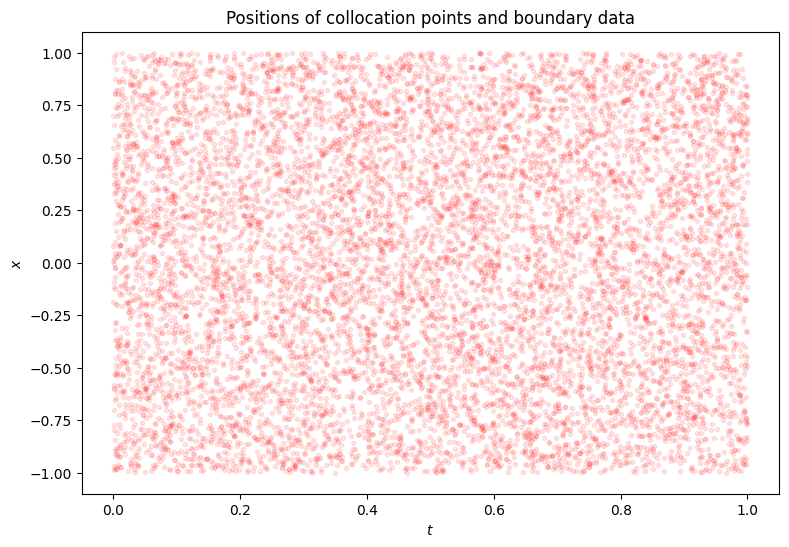

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_r.cpu().detach(), x_r.cpu().detach(), c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');

In [70]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_hidden_layers=11, num_neurons_per_layer=20):
        super(NeuralNetwork, self).__init__()

        # Model coefficients (Anything which needed to be discovered should be Parameter of the model, here it is cxx)
        self.ct = torch.tensor(1.0, requires_grad=False)
        self.cxx = nn.Parameter(torch.tensor(0.0, requires_grad=True))  # Diffusion coefficient
        self.cx = torch.tensor(0.0, requires_grad=False)
        self.c1 = torch.tensor(0.0, requires_grad=False)

        # Input layer (2D input: time + space)
        self.input_layer = nn.Linear(2, num_neurons_per_layer)

        # Activation function
        self.selu = nn.SELU()

        # Append Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer, num_neurons_per_layer)
            for _ in range(num_hidden_layers)
        ])

        # Output is 1D
        self.output_layer = nn.Linear(num_neurons_per_layer, 1)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)

    def forward(self, x):
        x = self.selu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.selu(layer(x))
        x = self.output_layer(x)
        return x

In [6]:
def compute_loss(model, X_r, X_d, u_data):
    X_r = X_r.detach().requires_grad_(True)

    # Split t and x to compute partial derivatives
    t, x = X_r[:, 0:1], X_r[:,1:2]

    # Determine residual
    u = model(torch.concat([t, x], axis=1))

    # Compute gradients
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),create_graph=True,allow_unused=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),create_graph=True,allow_unused=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u),create_graph=True,allow_unused=True)[0]

    # Get model coefficients
    ct = model.ct
    cxx = model.cxx
    cx = model.cx
    c1 = model.c1

    # Model discovery loss term
    loss = torch.mean(torch.square( ct*u_t + cxx*u_xx + cx*u_x + c1*u ))

    # Data loss term
    X_d = X_d.detach().requires_grad_(True)
    t_d, x_d = X_d[:, 0:1], X_d[:,1:2]
    u_d = model(torch.stack([t_d[:,0], x_d[:,0]], axis=1))
    loss += torch.mean(torch.square(u_d - u_data))

    # Coefficient regularization
    loss += 0.01*(torch.abs(cxx) + torch.abs(c1))

    return loss

In [64]:
# Initialize model aka tilde u
model = NeuralNetwork().to(device)

# Learning rate
lr = 1e-3

# Choose the optimizer
optimizer = optim.Adam(model.parameters(),lr=lr)

# Number of training epochs
N = 3000
hist = []

In [11]:
# Start timer
t0 = time()

for i in range(N+1):
    # Reset gradient of optimizer to 0
    optimizer.zero_grad()

    # Compute loss
    loss = compute_loss(model, X_r, X_d, u_data)
    loss.backward()

    # Perform gradient descent step
    optimizer.step()

    # Append current loss to hist
    hist.append(loss.item())

    # Output current loss after 50 iterates
    if i % 50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss.item()))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 7.25815594e-01
It 00050: loss = 4.02151383e-02
It 00100: loss = 1.98001359e-02
It 00150: loss = 1.81847028e-02
It 00200: loss = 1.56947114e-02
It 00250: loss = 1.44555578e-02
It 00300: loss = 1.36827566e-02
It 00350: loss = 1.15788588e-02
It 00400: loss = 1.01525998e-02
It 00450: loss = 1.10640135e-02
It 00500: loss = 2.25399770e-02
It 00550: loss = 1.13613466e-02
It 00600: loss = 9.64819919e-03
It 00650: loss = 5.99250151e-03
It 00700: loss = 6.48448803e-03
It 00750: loss = 4.22193529e-03
It 00800: loss = 3.88943963e-03
It 00850: loss = 3.53991706e-03
It 00900: loss = 4.60473122e-03
It 00950: loss = 4.16975468e-03
It 01000: loss = 4.24564211e-03
It 01050: loss = 8.96594301e-03
It 01100: loss = 2.30702083e-03
It 01150: loss = 2.55433191e-03
It 01200: loss = 2.29938258e-03
It 01250: loss = 1.95583981e-03
It 01300: loss = 1.96348596e-03
It 01350: loss = 2.28090305e-03
It 01400: loss = 1.88456778e-03
It 01450: loss = 2.00684927e-03
It 01500: loss = 2.06869305e-03
It 01550

In [ ]:
# Checking that the linear and diffusive coefficients
# combine to produce the correct model based on the training data

check = (-pi**2*model.cxx + model.c1)
print(check.cpu().detach().numpy()/(0.1*pi.numpy()**2)) # Exact value is 1 for a correct model

0.7506839891580187


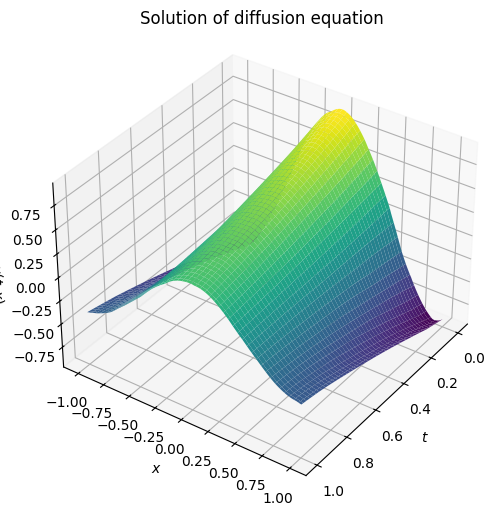

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 1000
tspace = np.linspace(tmin, tmax, N + 1)
xspace = np.linspace(xmin, xmax, N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(torch.tensor(Xgrid, dtype=dtype).to(device))

# Reshape upred
U = upred.cpu().detach().numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u(t,x)$')
ax.set_title('Solution of diffusion equation');

In [ ]:
import tensorflow as tf

def loadModel(file_path, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),num_hidden_layers=7):
    """To Load Tensorflow model and convert the model to pyTorch
    
        Note: This function will not work if the architecture of the model is different 
    """
    loaded_model = tf.keras.models.load_model(file_path, compile=False)
    loaded_weights = loaded_model.get_weights()
    pytorch_model = NeuralNetwork(num_hidden_layers=num_hidden_layers).to(device)

    # load the weights of the input layer
    pytorch_model.input_layer.weight = nn.Parameter(torch.tensor(loaded_weights[0].T).to(device))
    pytorch_model.input_layer.bias = nn.Parameter(torch.tensor(loaded_weights[1]).to(device))

    # load the weights of the hidden layer
    for i in range(1, num_hidden_layers+1):
        pytorch_model.hidden_layers[i-1].weight = nn.Parameter(torch.tensor(loaded_weights[2*i].T).to(device))
        pytorch_model.hidden_layers[i-1].bias = nn.Parameter(torch.tensor(loaded_weights[2*i+1]).to(device))

    pytorch_model.output_layer.weight = nn.Parameter(torch.tensor(loaded_weights[2*(num_hidden_layers+1)].T).to(device))
    pytorch_model.output_layer.bias = nn.Parameter(torch.tensor(loaded_weights[2*(num_hidden_layers+1)+1]).to(device))

    # now load the variables
    variables = [
        'pytorch_model.ct = nn.Parameter(torch.tensor(loaded_model.ct.numpy()).to(device))',
        'pytorch_model.cxx = nn.Parameter(torch.tensor(loaded_model.cxx.numpy()).to(device))',
        'pytorch_model.c1 = nn.Parameter(torch.tensor(loaded_model.c1.numpy()).to(device))',
        'pytorch_model.cx = nn.Parameter(torch.tensor(loaded_model.cx.numpy()).to(device))'
    ]

    for line in variables:
        try:
            exec(line)
        except Exception as e:
            pass

    return pytorch_model

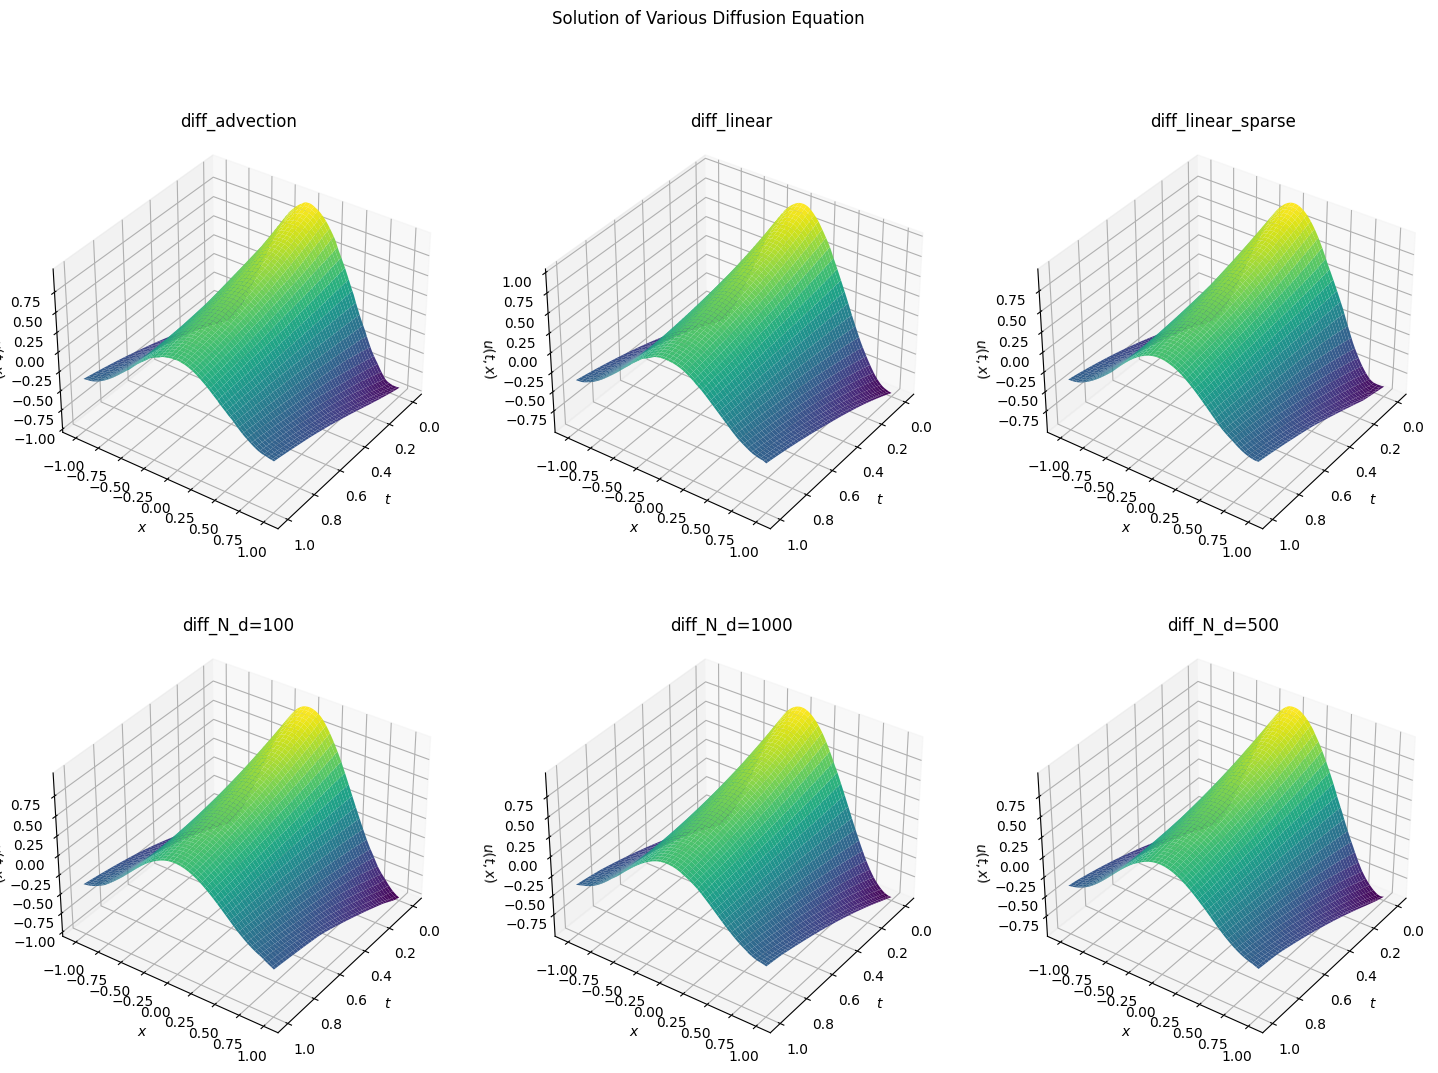

In [ ]:
# plotting different saved models 
from mpl_toolkits.mplot3d import Axes3D

# Seeing the forecasting of all trained models
fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw={'projection': '3d'})

# Set up meshgrid
N = 1000
tspace = np.linspace(tmin, tmax, N + 1)
xspace = np.linspace(xmin, xmax, N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

for i in range(2):
    for j in range(3):
        try:
            model = loadModel(f"../discovered_diffusion_models/{file_path[3*i+j]}")
            # Determine predictions of u(t, x)
            upred = model(torch.tensor(Xgrid, dtype=dtype).to(device))
            U = upred.cpu().detach().numpy().reshape(N+1,N+1)
        except:  # try changing the architecture of the model 
            model = loadModel(f"../discovered_diffusion_models/{file_path[3*i+j]}", num_hidden_layers=11)
            # Determine predictions of u(t, x)
            upred = model(torch.tensor(Xgrid, dtype=dtype).to(device))
            U = upred.cpu().detach().numpy().reshape(N+1,N+1)

        # Surface plot of solution u(t,x)
        ax = axes[i,j]
        ax.plot_surface(T, X, U, cmap='viridis')
        ax.view_init(35,35)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u(t,x)$')
        ax.set_title(f'{file_path[3*i+j]}');

fig.suptitle("Solution of Various Diffusion Equation")
plt.show()